In [5]:
import pandas as pd
df4 = pd.read_csv("/Users/xinyuanxu/Desktop/data viz/hw/airbnb_cleaned.csv")
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89651 entries, 0 to 89650
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   89651 non-null  int64  
 1   listing_name                 89651 non-null  object 
 2   host_id                      89651 non-null  int64  
 3   host_name                    89651 non-null  object 
 4   neighbourhood_group          89651 non-null  object 
 5   neighbourhood                89651 non-null  object 
 6   latitude                     89651 non-null  float64
 7   longitude                    89651 non-null  float64
 8   room_type                    89651 non-null  object 
 9   minimum_nights               89651 non-null  int64  
 10  number_of_reviews            89651 non-null  int64  
 11  review_id                    89651 non-null  float64
 12  review_date                  89651 non-null  object 
 13  reviewer_id     

/var/folders/46/fdrjqjdn3jq9yg03908v7r_80000gn/T/ipykernel_13049/387963764.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('price_bin')['review_scores_rating']


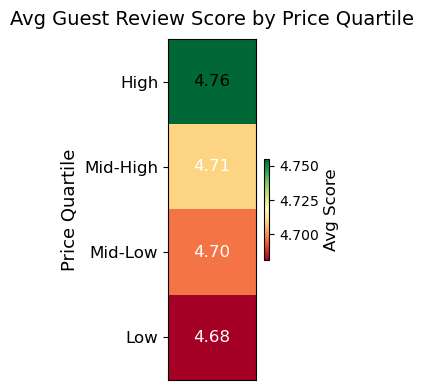

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Compute average review score by price quartile
df4['price_num'] = df4['price'].str.replace(r'[\$,]', '', regex=True).astype(float)
df4['price_bin'] = pd.qcut(
    df4['price_num'],
    q=4,
    labels=['Low','Mid‑Low','Mid‑High','High']
)
avg_score = (
    df4
    .groupby('price_bin')['review_scores_rating']
    .mean()
    .reindex(['Low','Mid‑Low','Mid‑High','High'])
)
heat_data = avg_score.values.reshape(-1, 1)

# 2. Plot heatmap with Low at bottom, High at top
fig, ax = plt.subplots(figsize=(3, 4))
cax = ax.imshow(
    heat_data,
    cmap='RdYlGn',            # red=low score, green=high score
    vmin=avg_score.min(),
    vmax=avg_score.max(),
    aspect='auto',
    origin='lower'            
)

mid = (avg_score.min() + avg_score.max()) / 2
for (i, j), val in np.ndenumerate(heat_data):
    color = 'white' if val < mid else 'black'
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=12)

ax.set_yticks(np.arange(len(avg_score)))
ax.set_yticklabels(avg_score.index, fontsize=12)
ax.set_xticks([])
ax.set_ylabel('Price Quartile', fontsize=13)
ax.set_title('Avg Guest Review Score by Price Quartile', pad=10, fontsize=14)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.05, pad=0.08)
cbar.set_label('Avg Score', fontsize=12)

plt.tight_layout()
plt.show()


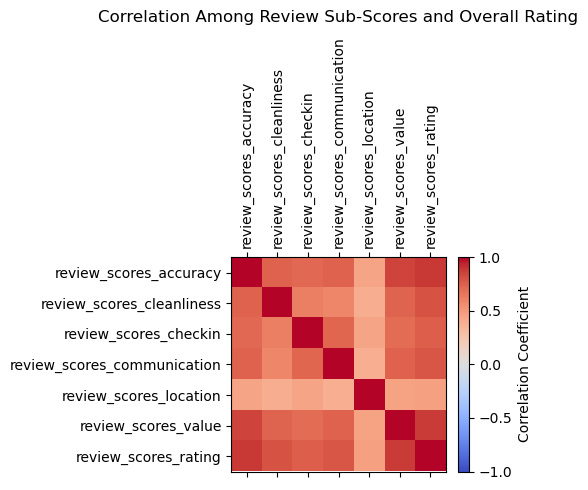

In [7]:
#CORRELATION MATRIX OF SUB‐SCORES vs OVERALL RATING
score_cols = [
    'review_scores_accuracy','review_scores_cleanliness',
    'review_scores_checkin','review_scores_communication',
    'review_scores_location','review_scores_value',
    'review_scores_rating'
]
corr = df4[score_cols].corr()

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label='Correlation Coefficient')
ax.set_xticks(range(len(score_cols)))
ax.set_xticklabels(score_cols, rotation=90)
ax.set_yticks(range(len(score_cols)))
ax.set_yticklabels(score_cols)
ax.set_title('Correlation Among Review Sub‑Scores and Overall Rating', pad=10)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/xinyuanxu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/46/fdrjqjdn3jq9yg03908v7r_80000gn/T/ipykernel_13049/520281465.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('price_bin')['sentiment']


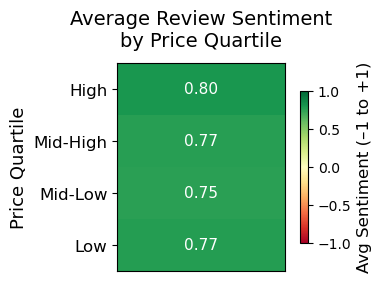

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. Sentiment calculation
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['review_content'].map(lambda txt: sia.polarity_scores(txt)['compound'])

# 2. Price cleaning & binning
df['price_num'] = df['price'].str.replace(r'[\$,]', '', regex=True).astype(float)
df['price_bin'] = pd.qcut(
    df['price_num'],
    q=4,
    labels=['Low', 'Mid‑Low', 'Mid‑High', 'High']
)

# 3. Aggregate
sent_by_price = (
    df
    .groupby('price_bin')['sentiment']
    .mean()
    .reindex(['Low','Mid‑Low','Mid‑High','High'])
)
heat_data = sent_by_price.values.reshape(-1, 1)

# 4. Plot (Low at bottom → High at top)
fig, ax = plt.subplots(figsize=(4, 3))

cax = ax.imshow(
    heat_data,
    cmap='RdYlGn',       # red = negative, green = positive
    vmin=-1, vmax=+1,    # VADER range
    aspect='auto',
    origin='lower'       # draw index 0 (Low) at bottom
)

# 5. Annotate each cell
midpoint = 0  # for VADER compound scores, 0 is the neutral midpoint
for (i, j), val in np.ndenumerate(heat_data):
    txt_color = 'white' if abs(val - midpoint) > 0.5 else 'black'
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=txt_color, fontsize=11)

# 6. Tidy axes
ax.set_yticks(np.arange(len(sent_by_price)))
ax.set_yticklabels(sent_by_price.index, fontsize=12)
ax.set_xticks([])  
ax.set_ylabel('Price Quartile', fontsize=13)
ax.set_title('Average Review Sentiment\nby Price Quartile', pad=12, fontsize=14)

# 7. Colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.04, pad=0.08)
cbar.set_label('Avg Sentiment (–1 to +1)', fontsize=12)

plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/xinyuanxu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/46/fdrjqjdn3jq9yg03908v7r_80000gn/T/ipykernel_13049/1021675509.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('price_bin')['sentiment']


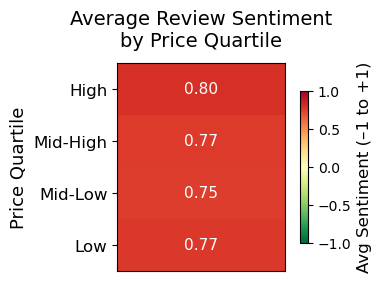

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. Sentiment calculation
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['review_content'].map(lambda txt: sia.polarity_scores(txt)['compound'])

# 2. Price cleaning & binning
df['price_num'] = df['price'].str.replace(r'[\$,]', '', regex=True).astype(float)
df['price_bin'] = pd.qcut(
    df['price_num'],
    q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

# 3. Aggregate
sent_by_price = (
    df
    .groupby('price_bin')['sentiment']
    .mean()
    .reindex(['Low','Mid-Low','Mid-High','High'])
)
heat_data = sent_by_price.values.reshape(-1, 1)

# 4. Plot (Low at bottom → High at top, red = higher sentiment)
fig, ax = plt.subplots(figsize=(4, 3))

cax = ax.imshow(
    heat_data,
    cmap='RdYlGn_r',     # reversed so green=low sentiment, red=high
    vmin=-1, vmax=+1,    # VADER range
    aspect='auto',
    origin='lower'       # draw index 0 (Low) at bottom
)

# 5. Annotate each cell
midpoint = 0
for (i, j), val in np.ndenumerate(heat_data):
    # white text on the darkest reds (high sentiment), black otherwise
    txt_color = 'white' if val > midpoint else 'black'
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=txt_color, fontsize=11)

# 6. Tidy axes
ax.set_yticks(np.arange(len(sent_by_price)))
ax.set_yticklabels(sent_by_price.index, fontsize=12)
ax.set_xticks([])  
ax.set_ylabel('Price Quartile', fontsize=13)
ax.set_title('Average Review Sentiment\nby Price Quartile', pad=12, fontsize=14)

# 7. Colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.04, pad=0.08)
cbar.set_label('Avg Sentiment (–1 to +1)', fontsize=12)

plt.tight_layout()
plt.show()
